<a href="https://colab.research.google.com/github/CarineMS/UFV/blob/main/Semana_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


***
## Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skopt import gp_minimize
from skopt.space import Real, Integer


from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBRegressor

# Estrutura do Código


1.   Load Data
2.   Train and Test Split
3.   Standard Scaler
4.   Linear Regression Model - Reference

    a. Features Analysing

    b. Features Selection

    c. Cross Validation

    d. Final Model Linear Regression

5.   XGBoost Model - Desenvolvimento

    a. Hyperparameter tuning
    
    b. Features Analysing

    c. Features Selection

    d. Cross Validation

    e. Final Model Linear Regression  



***
## Load Data

In [4]:
df = pd.read_csv('sample_data/dataset_problema2.csv')

X = df.drop(['id','Severidade'], axis=1)
y = df['Severidade']

***
## Dados de Treino e Teste

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

***
## Padronização das Variáveis

In [6]:
scaler = StandardScaler() #media 0 e desvio padrão 1

Xtrain_sc = scaler.fit_transform(Xtrain)
Xtest_sc = scaler.transform(Xtest)

# tranfsormando o array em dataframe
Xtrain_sc = pd.DataFrame(Xtrain_sc, columns=Xtrain.columns)
Xtest_sc = pd.DataFrame(Xtest_sc, columns=Xtest.columns)

# Modelo de Regressão Linear Múltipla



1.   Features Analysing
2.   Features Selection
3.   Cross Validation
4.   Final Model Linear Regression



***
## Features Analysing

In [7]:
ml = LinearRegression()

In [8]:
max_f = 20

lista_r2 = list()

for i in range(1, max_f+1):

  selector = RFE(ml, n_features_to_select=i, step=1)
  selector = selector.fit(Xtrain_sc, ytrain)
  mask = selector.support_

  features = Xtrain_sc.columns
  sel_features = features[mask]
  X_sel = Xtrain_sc[sel_features]

  score = cross_val_score(ml, X_sel, ytrain, cv = 10, scoring = 'neg_root_mean_squared_error')
  lista_r2.append(np.abs(np.mean(score)))

  print(np.abs(np.mean(score)))

22.999512866756277
20.978943999475103
12.213396211508062
11.313324687680517
8.638765107372922
8.67306852752466
8.758615941202397
8.882267359116286
7.610800020392202
7.501372965777241
7.698979572990166
7.651101456128744
7.655357291863628
7.786765054018021
7.865091875876468
7.954618243225215
8.051802922422864
8.087998611985732
8.197654755128694
8.252242790523852


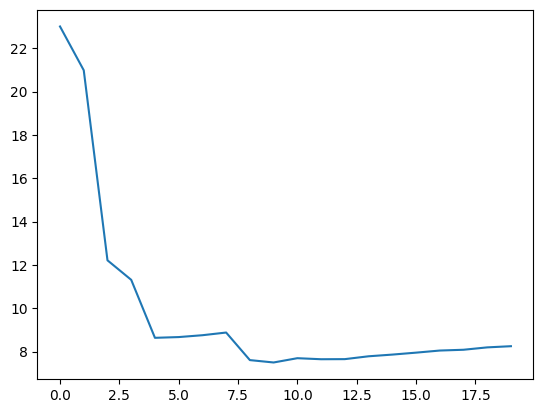

In [9]:
plt.plot(lista_r2)
plt.show()

In [10]:
n_features = 10 ##lista_r2.index(min(lista_r2))

***
## Features Selection

In [11]:
selector = RFE(ml, n_features_to_select = n_features, step=1)
selector = selector.fit(Xtrain_sc, ytrain)

mask = selector.support_
features = Xtrain_sc.columns
sel_features = features[mask]

sel_features

Index(['NDVI_d28', 'SAVI_d28', 'NDVI_d01', 'SAVI_d01', 'NDVI_d04', 'SAVI_d04',
       'NDVI_d08', 'SAVI_d08', 'GNDVI_d08', 'SR_d08'],
      dtype='object')

***
## Cross Validation

In [12]:
X_sel = Xtrain_sc[sel_features]
score = cross_val_score(ml, X_sel, ytrain, cv = 10, scoring = 'r2')

print(np.mean(score))


0.8655536026351045


***
## Final Model - Linear Regression

In [14]:
ml = LinearRegression()
ml.fit(X_sel, ytrain)

LinearRegression()

In [15]:
ypred = ml.predict(Xtest_sc[sel_features])

r2 =  ml.score(Xtest_sc[sel_features], ytest)
rmse = (mean_squared_error(ytest, ypred))**0.5
mae = mean_absolute_error(ytest, ypred)

print("RMSE", rmse)
print("MAE", mae)
print("R2", r2)

RMSE 7.539476072278346
MAE 6.344066348950323
R2 0.887634277870405


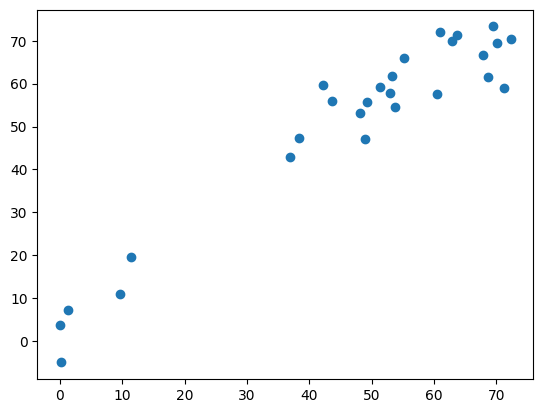

In [16]:
plt.scatter(ytest, ypred)

plt.show()

# Modelo XGBoost

1. Hyperparameter tuning
2. Features Analysing
3. Features Selection
4. Cross Validation
5. Final Model XGBoost

***
## XGboost


A minha estratégia para melhora da resposta do modelo é a utilização do XGboost, ou seja, substituir o modelo de Regressão Linear Múltipla pelo XGBoost, modelo baseado em árvores de decisão.

O modelo XGBoost entra no contexto de resolver um problema de regressão, em que seus hiperparâmetros foram ajustados por otimização Bayesiana afim de superar a métrica R2. Além disso, optou-se por aplicar a seleção de variáveis RFE para identificar as features mais relevantes e reduzir a dimensionalidade e complexidade do modelo, seguindo o exemplo disponibilizado pelo professor Sárvio Valente.

Para a hiperparametrização foram possibilitados ajustes no número de árvores, redução da taxa de aprendizado e refinamento dos parâmetros de regularização para melhorar a capacidade de generalização do modelo e minimização dos erros.


## Hyperparameter tuning

In [17]:
# Função de treino e avaliação do modelo XGBoost
def treinar_modelo_xg(params):
    objective = 'reg:squarederror'  # Objetivo para regressão
    n_estimators = params[0]  # Número de árvores
    learning_rate = params[1]  # Taxa de aprendizado
    max_depth = params[2]  # Profundidade máxima
    min_child_weight = params[3]  # Controla complexidade das árvores
    gamma = params[4]  # Controle de regularização
    subsample = params[5]  # Amostragem aleatória para evitar overfitting
    colsample_bytree = params[6]  # Fração de features usadas por árvore

    # Criar modelo
    model_xgb = XGBRegressor(
        objective=objective,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )

    # Avaliação com validação cruzada
    score = cross_val_score(model_xgb, Xtrain_sc, ytrain, cv=10, scoring="neg_mean_squared_error", n_jobs=-1)

    mean_score = np.mean(score)

    print(f"MSE Médio: {-mean_score:.5f}")

    return -mean_score  # Minimizar o erro quadrático médio (MSE)


In [18]:
# Definir espaço de busca dos hiperparâmetros
parametros = [
    Integer(100, 1000),  # n_estimators
    Real(0.1, 0.4, prior='log-uniform'),  # learning_rate
    Integer(5, 15),  # max_depth
    Integer(1, 10),  # min_child_weight
    Real(2, 10),  # gamma
    Real(0.5, 1),  # subsample
    Real(0.5, 1)  # colsample_bytree
]

In [19]:
# Otimização Bayesiana usando gp_minimize
otimos_xgb = gp_minimize(
    treinar_modelo_xg,
    parametros,
    random_state=42,
    verbose=1,
    n_calls=30,  # Número total de chamadas para otimização
    n_random_starts=10  # Quantidade de tentativas aleatórias antes da otimização
)

# Exibir melhores hiperparâmetros encontrados
print(f"Melhor MSE: {-otimos_xgb.fun:.5f}")
print(f"Melhores Hiperparâmetros: {otimos_xgb.x}")

Iteration No: 1 started. Evaluating function at random point.
MSE Médio: 72.64933
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9069
Function value obtained: 72.6493
Current minimum: 72.6493
Iteration No: 2 started. Evaluating function at random point.
MSE Médio: 69.23261
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0014
Function value obtained: 69.2326
Current minimum: 69.2326
Iteration No: 3 started. Evaluating function at random point.
MSE Médio: 69.19528
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.8294
Function value obtained: 69.1953
Current minimum: 69.1953
Iteration No: 4 started. Evaluating function at random point.
MSE Médio: 83.44226
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4895
Function value obtained: 83.4423
Current minimum: 69.1953
Iteration No: 5 started. Evaluating function at random point.
MSE Médio: 73.38908
Iteration No: 5 ended. Evaluation done at random point.
Ti

***
## Features Analysing

In [25]:
n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample,  colsample_bytree = otimos_xgb.x

model_xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )

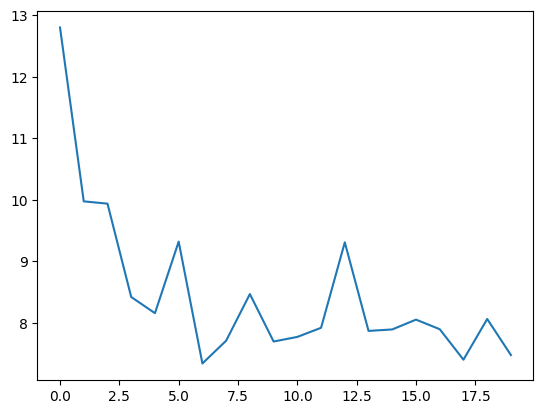

In [35]:
max_f = 20
lista_r2 = list()

for i in range(1, max_f+1):

  selector = RFE(model_xgb, n_features_to_select=i, step=1)
  selector = selector.fit(Xtrain_sc, ytrain)
  mask = selector.support_

  features = Xtrain_sc.columns
  sel_features = features[mask]
  X_sel = Xtrain_sc[sel_features]

  score = cross_val_score(model_xgb, X_sel, ytrain, cv = 10, scoring = 'neg_root_mean_squared_error')
  lista_r2.append(np.abs(np.mean(score)))

plt.plot(lista_r2)
plt.show()

In [36]:
n_features = lista_r2.index(min(lista_r2))
n_features

6

***
## Features Selection

In [23]:
selector = RFE(model_xgb, n_features_to_select = n_features, step=1)
selector = selector.fit(Xtrain_sc, ytrain)

mask = selector.support_
features = Xtrain_sc.columns
sel_features = features[mask]

sel_features

Index(['NDVI_d28', 'GNDVI_d28', 'GNDVI_d01', 'NDVI_d08', 'GNDVI_d08',
       'MCARI1_d08'],
      dtype='object')

In [24]:
# X_sel = Xtrain_sc[sel_features]  # Mantendo apenas as melhores variáveis

# Rodar otimização novamente com X_sel
otimos_xgb = gp_minimize(
    treinar_modelo_xg,  # Função de treino
    parametros,  # Espaço de busca
    random_state=42,
    verbose=1,
    n_calls=30,
    n_random_starts=10
)

print(f"Melhores Hiperparâmetros Após Feature Selection: {otimos_xgb.x}")


Iteration No: 1 started. Evaluating function at random point.
MSE Médio: 72.64933
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.6075
Function value obtained: 72.6493
Current minimum: 72.6493
Iteration No: 2 started. Evaluating function at random point.
MSE Médio: 69.23261
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8733
Function value obtained: 69.2326
Current minimum: 69.2326
Iteration No: 3 started. Evaluating function at random point.
MSE Médio: 69.19528
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7117
Function value obtained: 69.1953
Current minimum: 69.1953
Iteration No: 4 started. Evaluating function at random point.
MSE Médio: 83.44226
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4709
Function value obtained: 83.4423
Current minimum: 69.1953
Iteration No: 5 started. Evaluating function at random point.
MSE Médio: 73.38908
Iteration No: 5 ended. Evaluation done at random point.
Ti

***
## Cross Validation

In [27]:
X_sel = Xtrain_sc[sel_features]
score = cross_val_score(model_xgb, X_sel, ytrain, cv = 10, scoring = 'r2')

print(np.mean(score))

0.8563130401421377


***
## Final Model - XGBoost

In [30]:
n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample,  colsample_bytree = otimos_xgb.x

model_xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )
model_xgb.fit(X_sel, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6632703844029177, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=9.413270926350355,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.32144447396151926,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=128, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [31]:
ypred = model_xgb.predict(Xtest_sc[sel_features])

r2 =  model_xgb.score(Xtest_sc[sel_features], ytest)
rmse = (mean_squared_error(ytest, ypred))**0.5
mae = mean_absolute_error(ytest, ypred)

print("RMSE", rmse)
print("MAE", mae)
print("R2", r2)

RMSE 7.014597646789257
MAE 5.8061412257176865
R2 0.9027348987792481
